<a href="https://colab.research.google.com/github/nlimsupt/data-analytics-portfolio/blob/main/Bank_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BIA 652 Final Project: Bank Marketing Prediction**

# **Section 1: Problem Definition**

**Research Question**

How do different multivariate classification models perform in predicting whether a bank client will subscribe to a term deposit, and which features contribute most to the prediction?

**Motivation and Significance**

Term deposits provide stable funding for banks, but subscription rates are low and broad marketing campaigns are often inefficient and costly. By identifying customers most likely to subscribe, banks can target outreach more effectively and reduce expenses. The Bank Marketing dataset offers rich customer and campaign information, enabling the use of machine learning to improve targeting. This motivates comparing classification models to determine
which best predicts term-deposit subscription.

# **Section 2: Data Analysis Task and Methoddology**

**Data Analysis Task**

  The primary task is binary classification, predicting whether a customer subscribes to a term deposit (y=1) or
not (y=0)

**Multivariate Techniques**

**1.   Logistic Regression**

• Chosen for interpretability and as a common baseline model.

• Provides insight into linear relationships between customer attributes and subscription behavior.

**2.   Random Forest Classifier**

• Selected for its ability to capture nonlinear relationships and interactions among variables.

• Generally robust to noise and suitable for datasets with mixed variable types.

**Model Assumptions**

**1.   Assumptions of Logistic Regression**

• Linearity of log-odds: Assumes predictors relate linearly to log-odds of the outcome. Scaling
numerical features supports model stability.

• Independence of observations: Each observation represented an independent customer.

• No perfect multicollinearity: Checked through correlation analysis; encoding helps reduce
redundancy.

• Sensitive to class imbalance: Addressed using SMOTE within the training pipeline.

**2.   Assumptions of Random Forest Classifier**

• No strict statistical assumptions

• Can handles nonlinearities and interactions.

• Still affected by class imbalance, which was mitigated using SMOTE in the training process.

In [ ]:
pip install ucimlrepo

# **Section 3: Data Description**

**Dataset Source**

The dataset used in this project is the Bank Marketing dataset from the UCI Machine Learning Repository (ID: 222). It contains data from direct marketing campaigns conducted by a Portuguese retail bank. The objective of these campaigns was to encourage clients to subscribe to a long-term deposit product. The dataset includes 45,211 observations and 16 variables, with one binary target variable indicating whether a client subscribed to a term deposit ("yes" = 1, "no" = 0).

**Variables**

**Demographic Variables:**

1. age (numerical): client's age.
2. job (categorical):  type of job ("blue-collar", "management", "technician", "admin.", "services", "retired", "self-employed", "entrepreneur", "unemployed", "housemaid", "student", "unknown").
3. marital (categoriacal): marital status ("married", "single", "divorced").
4. education (categorical): educational level ("primary", "secondary", "tertiary", "unknown").

**Financial Status Variables:**

5. default (categorical): has credit in default? ("yes", "no", "unknown").
6. housing (categorical): has housing loan? ("yes", "no", "unknown").
7. loan (categorical): has personal loan? ("yes", "no", "unknown").
8. balance (numerical): balance of the individual.

**Marketing Interaction Variables:**

9. contact (categorical): communication channel("cellular", "telephone", "unknown").
10. day_of_week (categorical): Day of contact (numeric label 1-31 representing the calendar day).
11. month (categorical): month of contact.
12. duration (numerical): length of last contact in seconds.
13. campaign (numerical): number of contacts during campaign.
14. pdays (numerical): days since last contact (-1 indicates no previous contact)
15. previous (numerical): number of prior contacts in previous campaigns.
16. poutcome (categorical): outcome of the previous marketing campaign.

**Target Variable:**

17. y (binary): whether the client subscribed to a term deposit ("yes" = 1, "no" = 0)




In [ ]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, classification_report, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA

In [ ]:
# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# create DataFrame
X = pd.DataFrame(bank_marketing.data.features, columns=bank_marketing.variables['name'][:-1])
y = pd.Series(bank_marketing.data.targets.squeeze(), name='y')
df = pd.concat([X, y], axis=1)

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [ ]:
df.shape

(45211, 17)

In [ ]:
df[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']].describe()

,age,balance,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


In [ ]:
df.isna().sum()

,0
age,0
job,288
marital,0
education,1857
default,0
balance,0
housing,0
loan,0
contact,13020
day_of_week,0


**Handling Missing Values**

Several categorical variables contained missing values:

1. job: 288 missing values.
2. education: 1,857 missing values.
3. contact: 13,020 missing values.
4. poutcome: 36,959 missing values.

These categorical variables were replaced with the category "unknown" to preserve information and avoid unnecessary row deletion.

**Feature Types and Modeling Considerations**

Variables were categorized for preprocessing as follows:

1. Categorical variables (to be One-Hot Encoded) include job, marital, education, default, housing, loan, contact, month, poutcome, day_of_week.

2. Numerical variables (to be scaled) include age, balance, duration, campaign, pdays, previous.

Note: Although day_of_week appears numeric, its values represent calendar days and do not carry ordinal meaning. Therefore, it is treated as a categorical variable.




In [ ]:
# identify categorical columns
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols = [c for c in cat_cols if c != 'y']
cat_cols.append('day_of_week')

# identify numerical comlumns
num_cols = df.select_dtypes(include=['int64']).columns.tolist()
num_cols = [c for c in num_cols if c != 'day_of_week']

print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)

# fill missing values with unknown
df[cat_cols] = df[cat_cols].fillna('unknown')

Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'day_of_week']
Numerical columns: ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']


**Duplicate Records**

The dataset contains no duplicated rows (df.duplicated().sum() = 0) .

In [ ]:
df.duplicated().sum()

np.int64(0)

**Class Balance**

The target variable is moderately imbalanced:

"no" = 0: 39,992 records (88.3%)

"yes" = 1: 5,289 records (11.7%)

This indicates that models will incorporate class weighting and performance metrics that account for imbalance (e.g., F1-score, ROC-AUC).

In [ ]:
# separate X, y for modeling
X = df.drop('y', axis=1)
y = df['y'].map({'no': 0, 'yes': 1})

print(y.value_counts())
print("\nClass proportion (%):")
print(np.round(y.value_counts(normalize=True) * 100, 2))

y
0    39922
1     5289
Name: count, dtype: int64

Class proportion (%):
y
0    88.3
1    11.7
Name: proportion, dtype: float64


**Exploratory Data Analysis**

**Summary of Categorical Variables**

**1. Job**
- Subscription rates vary significantly by job type.
- Retired, students, and management show higher subscription ratios.
- Blue-collar workers show the lowest conversion rates.

**2. Marital Status**
- Single customers have slightly higher subscription rates compared to married and divorced individuals.

**3. Education**
- Higher education (tertiary) is associated with higher subscription likelihood.
- Customers with primary education or unknown levels show lower rates.

**4. Default**
- Almost all customers have no default.
- Subscription rates do not differ meaningfully.

**5. Housing Loan**
- Customers without housing loans subscribe at a higher rate.

**6. Personal Loan**
- Customer without personal loans are more likely to subscribe.

**7. Contact Type**
- Cellular contact produces much higher  subscription rates than telephone or unknown.

**8. Month**
- subscription rates vary widely across months.

**9. Previous Campaign Outcome (poutcome)**
- Customers previously marked as success have a substantially higher chance of subscribing again.

**10. Day of Week**
- Distribution is relatively uniform with minimal differences across days.

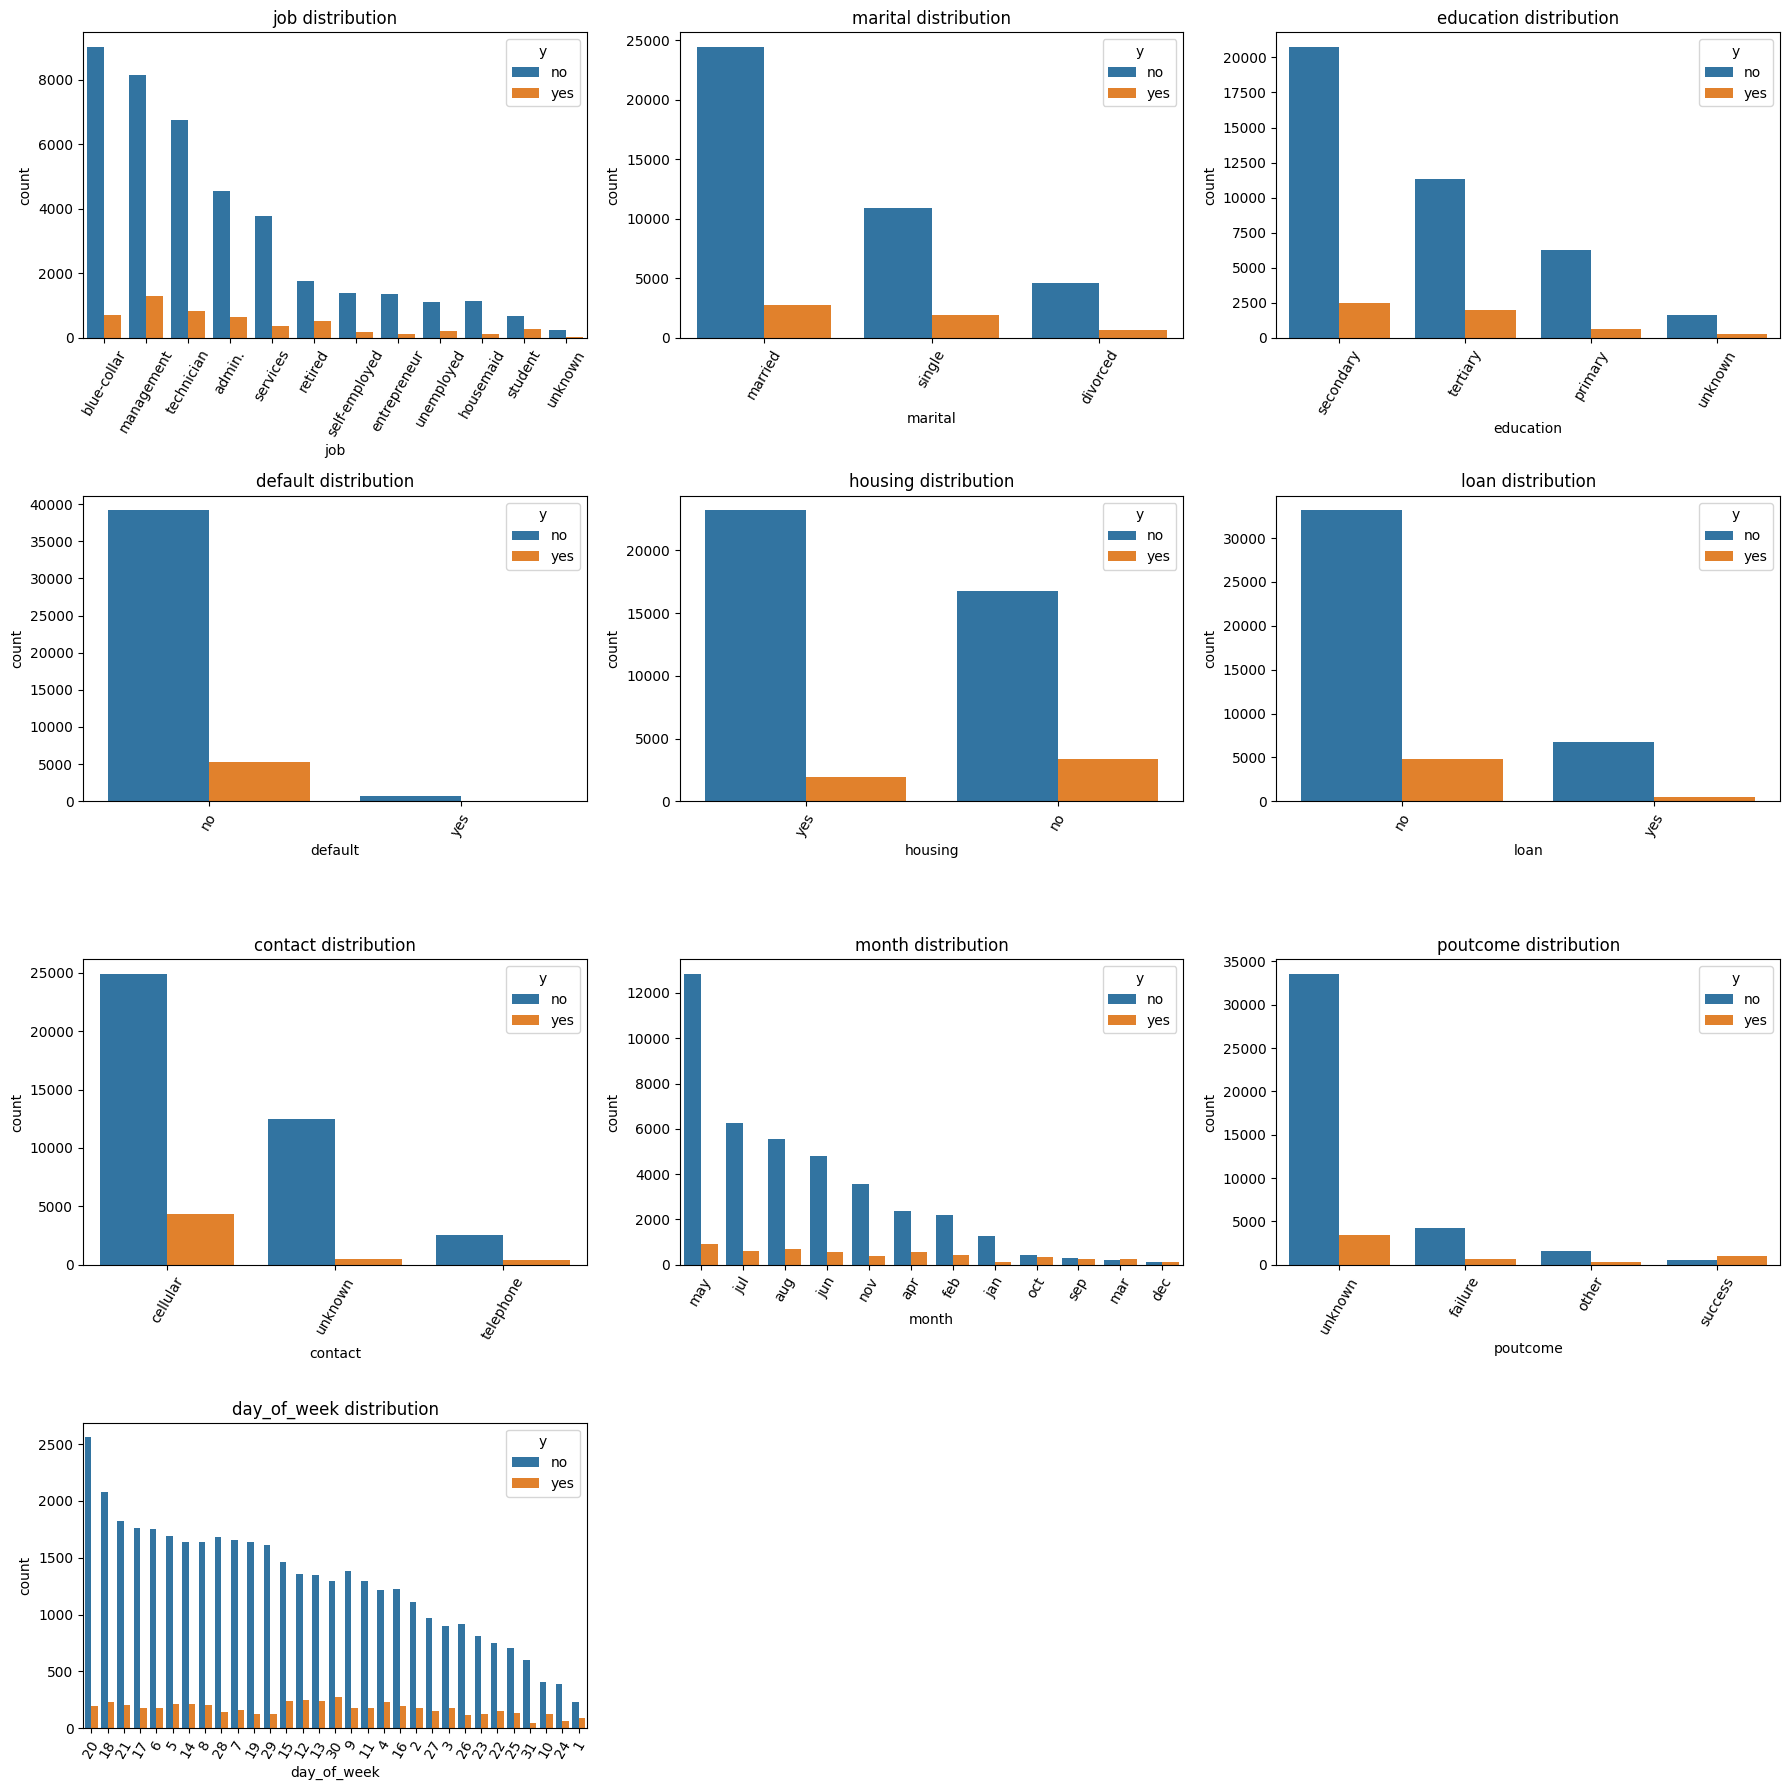

In [ ]:
# EDA: categorical distributions vs y
rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
axes = axes.flatten()

for i, col_name in enumerate(cat_cols):
    order = df[col_name].value_counts().index
    sns.countplot(data=df, x=col_name, ax=axes[i], hue='y', order = order)
    axes[i].set_title(f"{col_name} distribution", fontsize=12)
    axes[i].tick_params(axis="x", rotation=60)

for j in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Summary of Numerical Variables**

- Numerical features exhibit strong right-skewness and contain outliers, especially in balance, duration, campaign, pdays, and previous.

- Correlation analysis shows no multicollinearity concerns, with all pairwise correlations below 0.5.


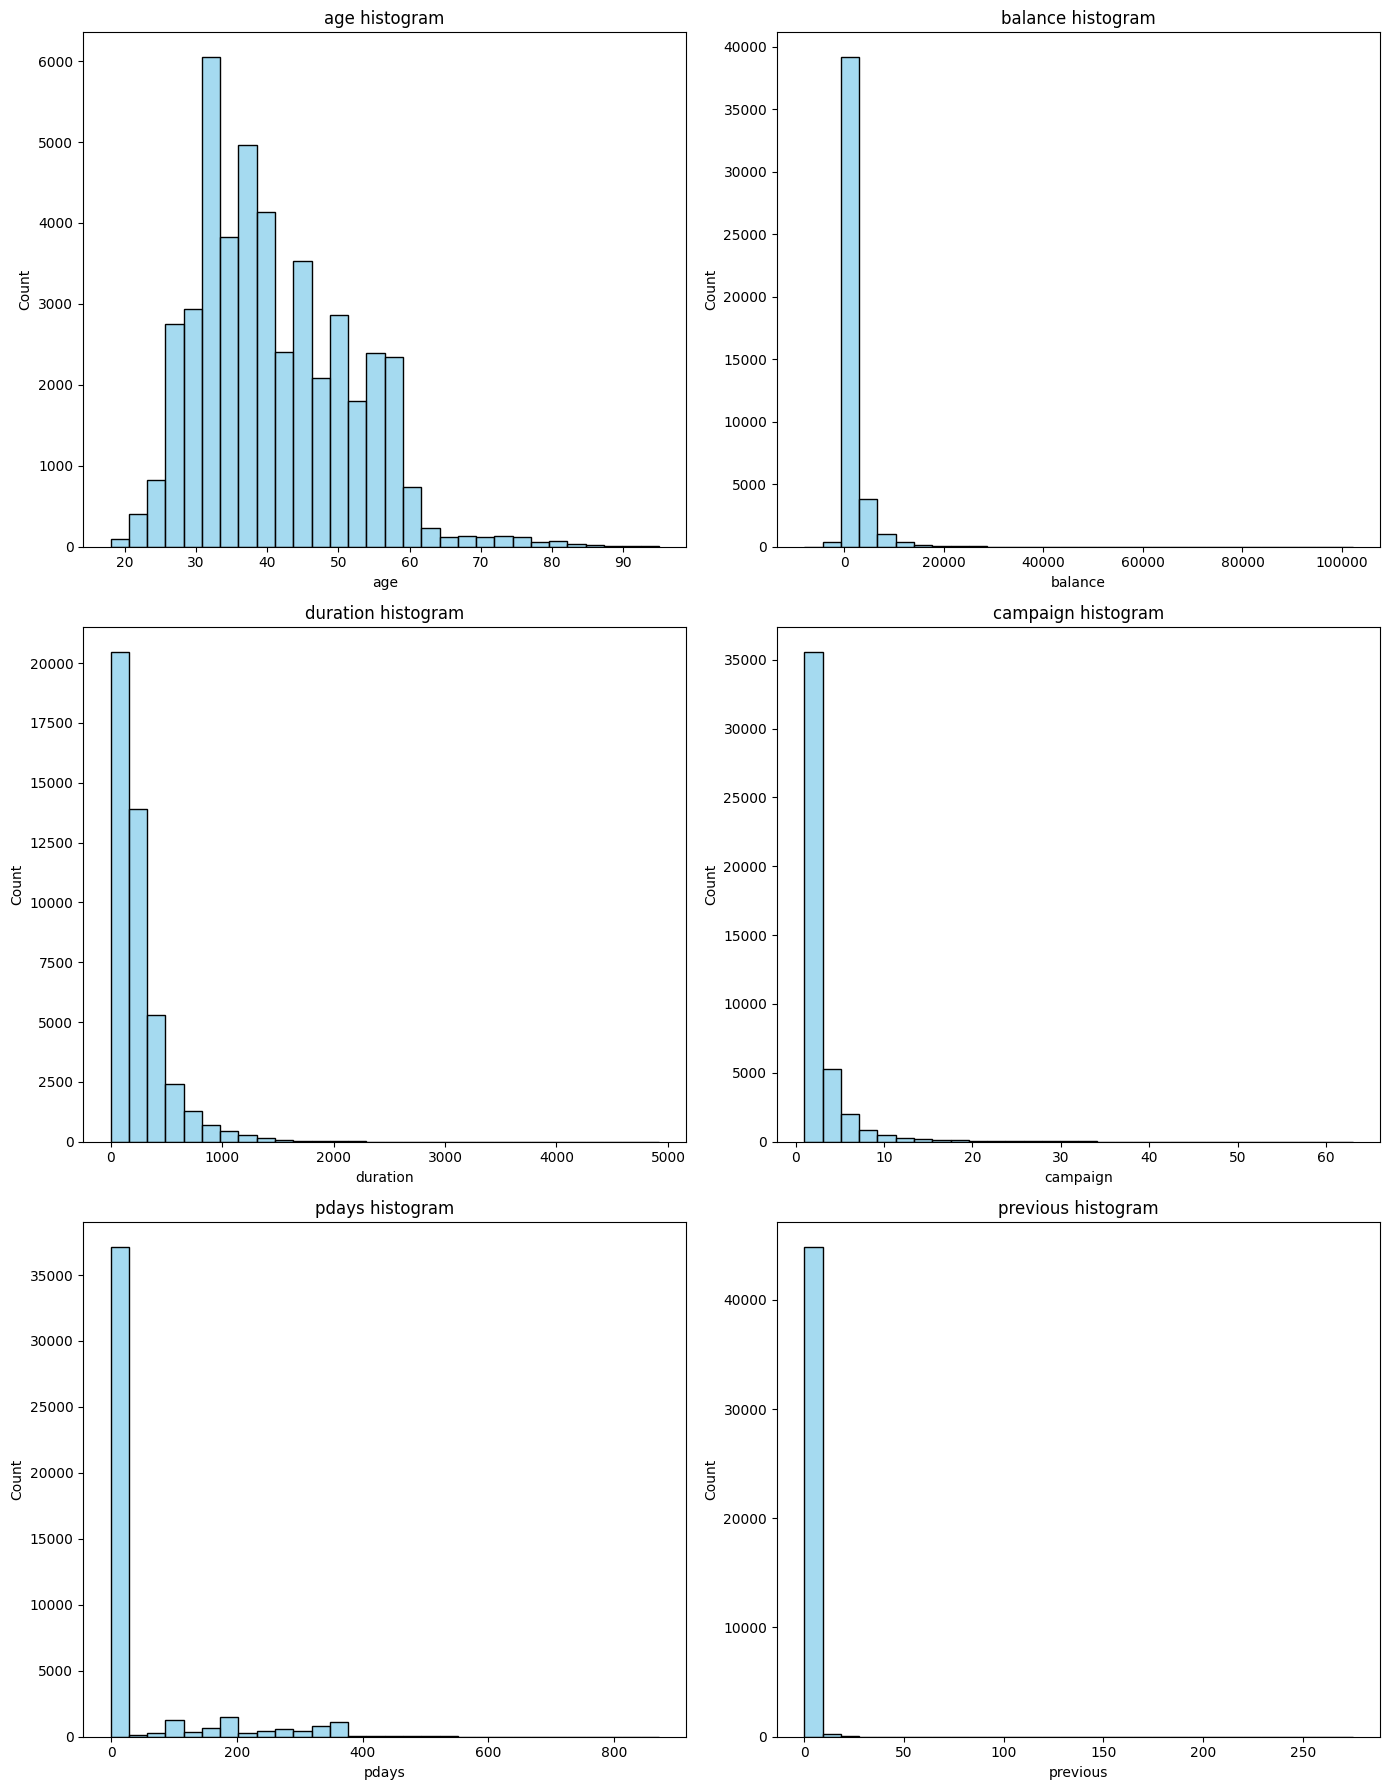

In [ ]:
# EDA: histograms of numerical features
rows, cols = 3, 2
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 18))
axes = axes.flatten()

# plot histograms
for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=30, kde=False, color="skyblue", ax=axes[i])
    axes[i].set_title(f"{col} histogram", fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

# remove unused axes
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

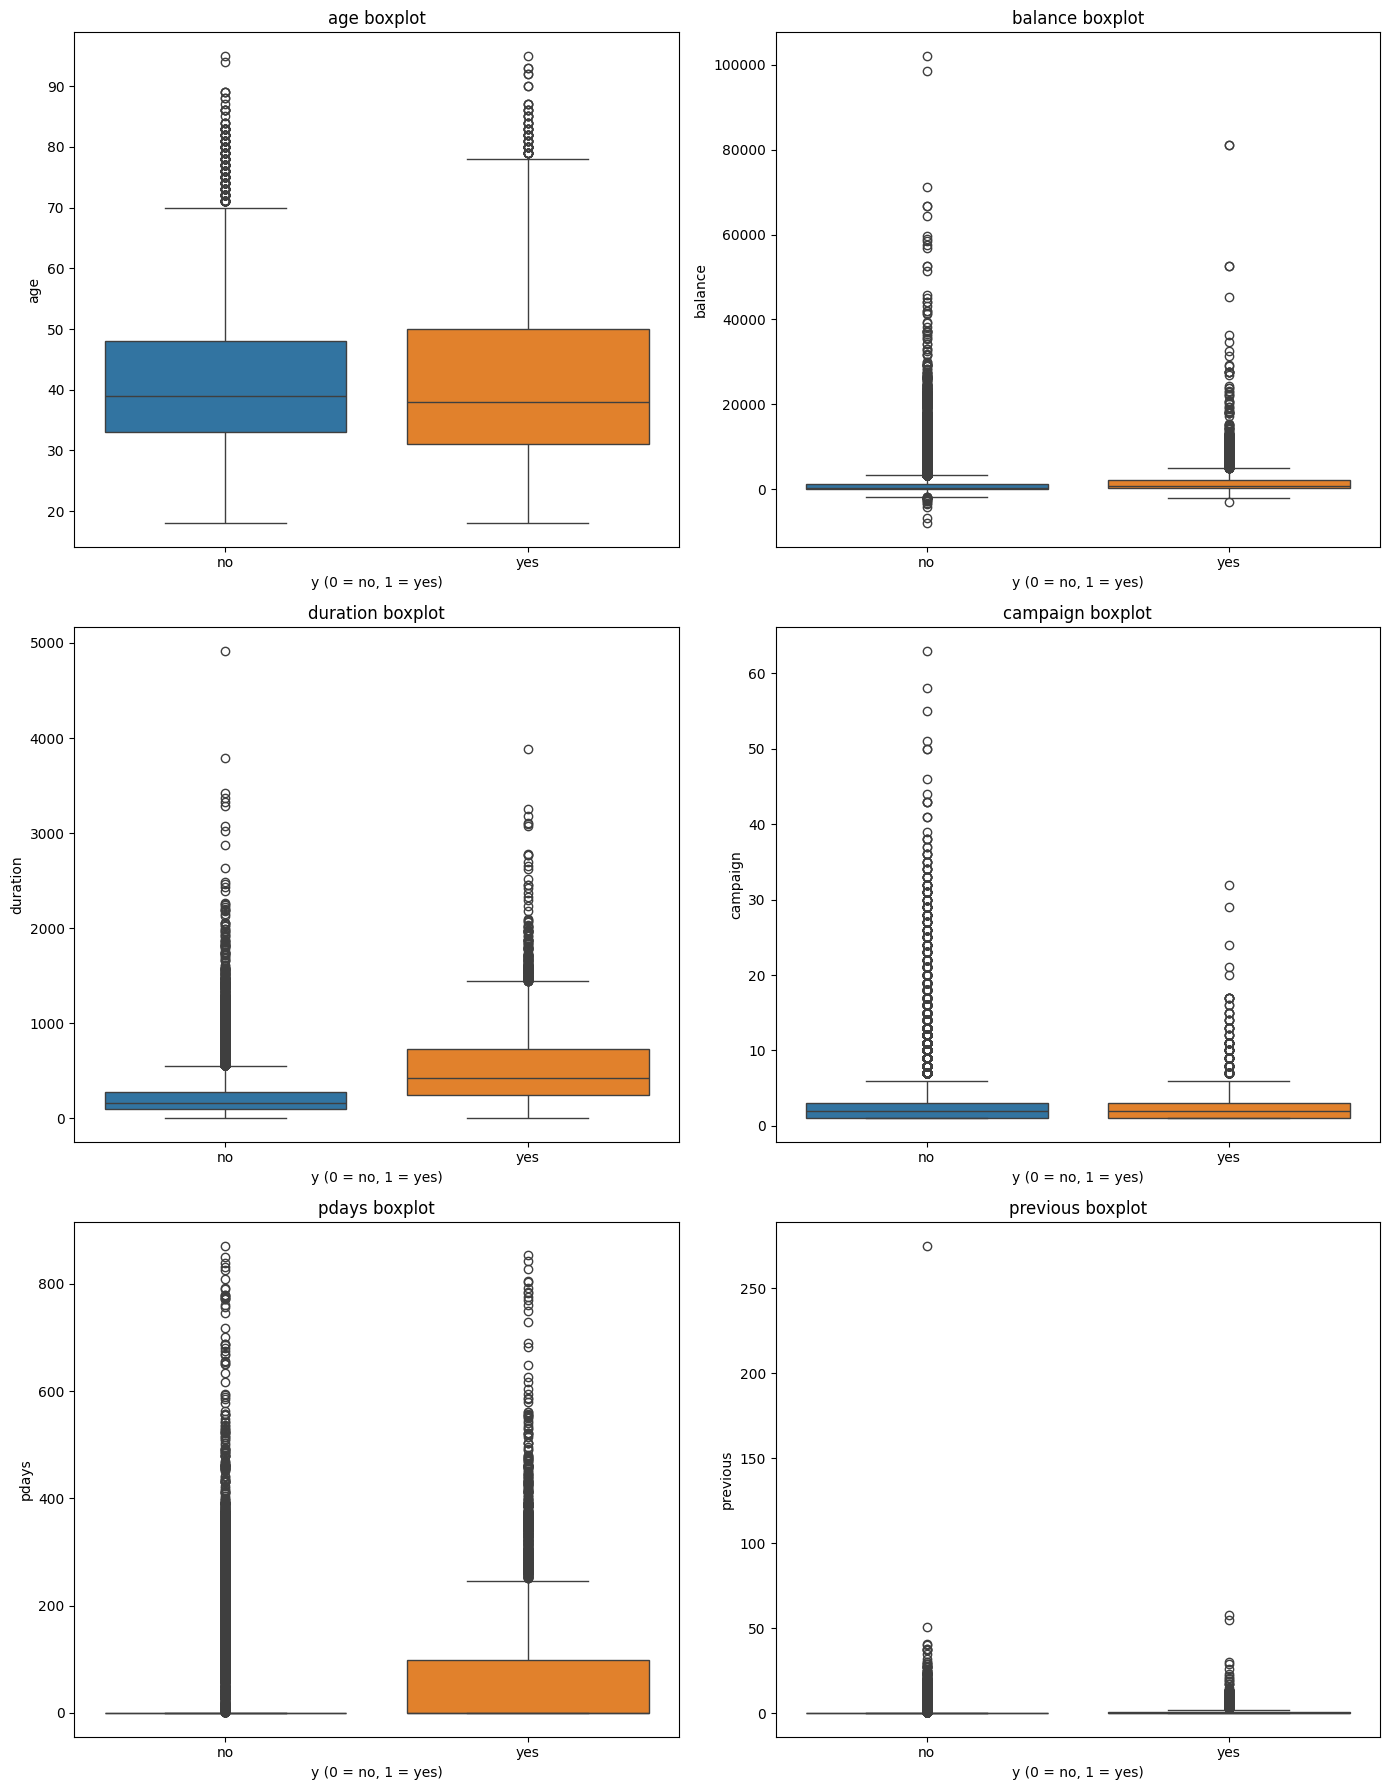

In [ ]:
# EDA: Boxplot of Numerical Features
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 18))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x='y', y=col, hue='y', ax=axes[i])
    axes[i].set_title(f"{col} boxplot", fontsize=12)
    axes[i].set_xlabel("y (0 = no, 1 = yes)")
    axes[i].set_ylabel(col)

# Remove unused axes
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

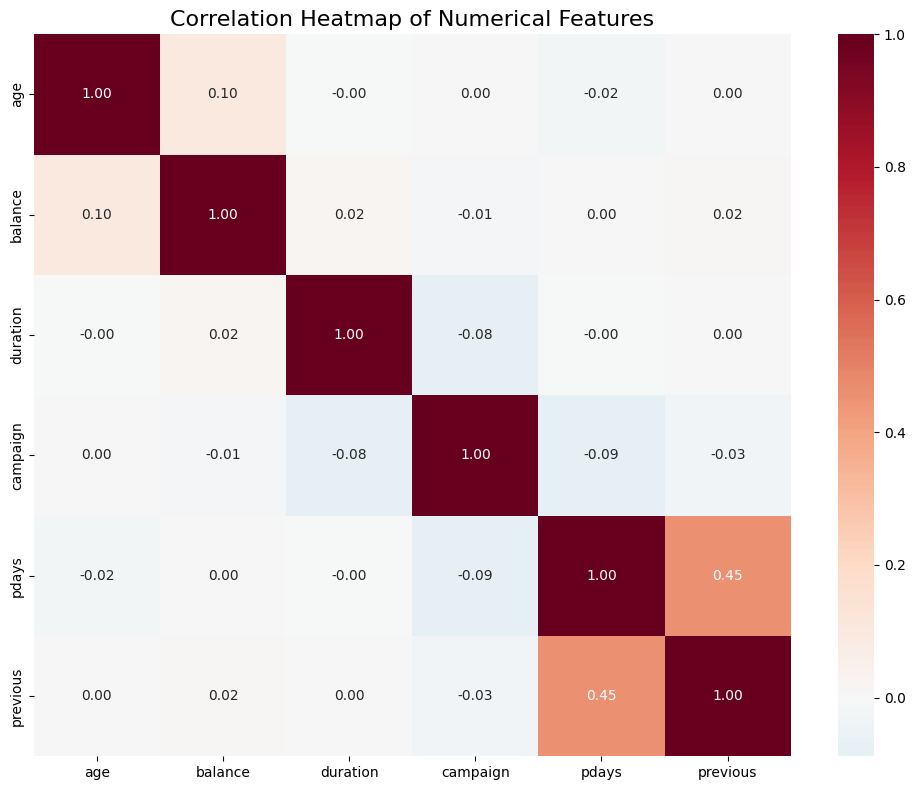

In [ ]:
# EDA: correlation heatmap of numerical features
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0, cbar=True)

plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

**Feature Removal**

The variable 'duration' was removed prior to model training. Although highly predictive, it is known to be data-leaking because the duration of the call is only known after the campaign contact is completed since including it would provide the model with information unavailable at prediction time, leading to overly optimistic and unrealistic results.
Therefore, duration was excluded from both training and evaluation.

In [ ]:
# drop duration for avoiding data leakage

X = df.drop(columns=['y', 'duration'])
y = df['y'].map({'no': 0, 'yes': 1})

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='int64').columns.tolist()

# **Section 4: Analysis and Results**

**Modeling Approach**

Four multivariate classification models were implemented to predict customer subscription:
1. Logistic Regression with SMOTE
2. Logistic Regression with PCA and SMOTE
3. Random Forest with SMOTE
4. Random Forest with PCA and SMOTE

All models were implemented using imbalanced-learn pipelines to ensure that preprocessing, SMOTE oversampling, PCA transformation (for PCA models), and model fitting occur only within the training folds during cross-validation, thereby preventing data leakage and ensuring fair evaluation.


Model evaluation consisted of:
- 5-fold stratified cross-validation (on training set)
- Test-set performance using:
  - Recall (class 1)
  - Precision (class 1)
  - F1-score (class 1)
  - ROC-AUC
  - PR-AUC
  - Confusion matrix

**Preprocessing and Feature Engineering**

- Numerical variable were standardized using StandardScaler.
- Categorical variables were transformed using OneHotEncoder (drop-first).
- SMOTE (sampling_strategy = 0.3) was applied inside each pipeline after preprocessing
- PCA was applied only to the preprocessed numerical/categorical feature matrix; the optimal number of components was selected based on a systematic performance comparison.

**PCA Component Selection**

To determine an appropriate dimensionality, PCA was applied to the processed training data.

- Cumulative variance analysis showed that 95% variance is reached at 21 components.
- CV experiments were conducted for n_components = 5, 10, 15, ..., 40, evaluating each setting using the F1-score of the minority class.

The results showed that:
- Logistic Regression performance improved gradually but peaked at 35 components.
- Random forest performance increased consistently and peaked at 39 components.

Since Random Forest is the stronger model, and PCA improved its performance meaningfully, 39 principal components were selected for the PCA-based pipelines.

**Cross-Validation Results**

Cross-validation was performed using 5-fold stratified CV on the training set.
The scoring metric was F1-score of the minority class (y=1), which is more informative than accuracy for imbalanced data.

**Logistic Regression (SMOTE)**
- Mean F1-score (CV): 0.3665
- Std: 0.0029

**Logistic Regression (PCA + SMOTE)**
- Mean F1-score (CV): 0.3673
- Std: 0.0043

**Random Forest (SMOTE)**
- Mean F1-score (CV): 0.4255
- Std: 0.0073

**Random Forest (PCA + SMOTE)**
- Mean F1-score (CV): 0.4589
- Std: 0.0067



**Test-Set Evaluation**

**Logistic Regression (SMOTE):**

- Precision (class 1) : 0.2685
- Recall (class 1)   : 0.6276
- F1-Score (class 1) : 0.3761
- PR-AUC    : 0.4082
- ROC-AUC   : 0.7699

**Logistic Regression (PCA + SMOTE):**

- Precision (class 1) : 0.2673
- Recall (class 1)   : 0.6248
- F1-Score (class 1) : 0.3744
- PR-AUC    : 0.4082
- ROC-AUC   : 0.7697

**Random Forest (SMOTE)**

-  Precision (class 1) : 0.3363
-  Recall (class 1)    : 0.5784
-  F1-score (class 1)  : 0.4253
-  ROC-AUC       : 0.7841
-  PR-AUC        : 0.4181

**Random Forest (PCA + SMOTE):**

- Precision (class 1) : 0.4139
- Recall (class 1)   : 0.5359
- F1-Score (class 1) : 0.4671
- PR-AUC    : 0.4351
- ROC-AUC   : 0.7916

According to the evaluation results, PCA does not help Logistic Regression. This is expected because Logistic Regression benefits less from PCA unless multicollinearity is extreme. On the other hand, PCA significantly boosts Random Forest as PCA reduces noisy features and improves the stability of tree splits.


**Overall Interpretation**

Although Logistic Regression achieves higher recall, Random Forest shows:
- Higher precision
- Higher F1-score
- Higher PR-AUC and ROC-AUC
- Greater stability across CV folds

PCA further amplifies Random Forest's performance, suggesting that dimensionality reduction helps tree-based models by mitigating noisy or redundant features.

Therefore, Random Forest with PCA and SMOTE is selected as the preferred model, as it provides the best balance between identifying positive cases and reducing false positives.

In [ ]:
# train-test split (stratified)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("\nTrain class distribution:\n", y_train.value_counts(normalize=True).round(3))

Train size: (36168, 15)  Test size: (9043, 15)

Train class distribution:
 y
0    0.883
1    0.117
Name: proportion, dtype: float64


In [ ]:
# numerical: StandardScaler
num_transformer = Pipeline([('scaler', StandardScaler())])

# categorical: OneHotEncoder (drop first level, ignore unseen categories)
cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

print("X_train_prepared shape:", X_train_prepared.shape)
print("X_test_prepared  shape:", X_test_prepared.shape)

X_train_prepared shape: (36168, 41)
X_test_prepared  shape: (9043, 41)


In [ ]:
# PCA fit

pca_full = PCA(random_state=42)
pca_full.fit(X_train_prepared)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

for i, cv in enumerate(cumulative_variance):
  print(f"Components: {i+1}, Cumulative Variance: {cv:.4f}")

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components for 95% variance: {n_components_95}")

Components: 1, Cumulative Variance: 0.1736
Components: 2, Cumulative Variance: 0.2999
Components: 3, Cumulative Variance: 0.4210
Components: 4, Cumulative Variance: 0.5230
Components: 5, Cumulative Variance: 0.6136
Components: 6, Cumulative Variance: 0.6758
Components: 7, Cumulative Variance: 0.7296
Components: 8, Cumulative Variance: 0.7696
Components: 9, Cumulative Variance: 0.8030
Components: 10, Cumulative Variance: 0.8245
Components: 11, Cumulative Variance: 0.8452
Components: 12, Cumulative Variance: 0.8627
Components: 13, Cumulative Variance: 0.8779
Components: 14, Cumulative Variance: 0.8919
Components: 15, Cumulative Variance: 0.9043
Components: 16, Cumulative Variance: 0.9150
Components: 17, Cumulative Variance: 0.9247
Components: 18, Cumulative Variance: 0.9315
Components: 19, Cumulative Variance: 0.9381
Components: 20, Cumulative Variance: 0.9444
Components: 21, Cumulative Variance: 0.9502
Components: 22, Cumulative Variance: 0.9552
Components: 23, Cumulative Variance: 0.95


=== Testing PCA with 5 components ===

=== Testing PCA with 10 components ===

=== Testing PCA with 15 components ===

=== Testing PCA with 20 components ===

=== Testing PCA with 25 components ===

=== Testing PCA with 30 components ===

=== Testing PCA with 35 components ===

=== Testing PCA with 40 components ===

=== RESULTS SUMMARY ===
                 model  n_components   mean_f1    std_f1
0         LogReg + PCA             5  0.285881  0.003719
1   RandomForest + PCA             5  0.318511  0.007757
2         LogReg + PCA            10  0.302555  0.004096
3   RandomForest + PCA            10  0.366907  0.007388
4         LogReg + PCA            15  0.309894  0.005671
5   RandomForest + PCA            15  0.379627  0.007718
6         LogReg + PCA            20  0.322871  0.003531
7   RandomForest + PCA            20  0.395562  0.011062
8         LogReg + PCA            25  0.347875  0.003915
9   RandomForest + PCA            25  0.416558  0.010383
10        LogReg + PCA       

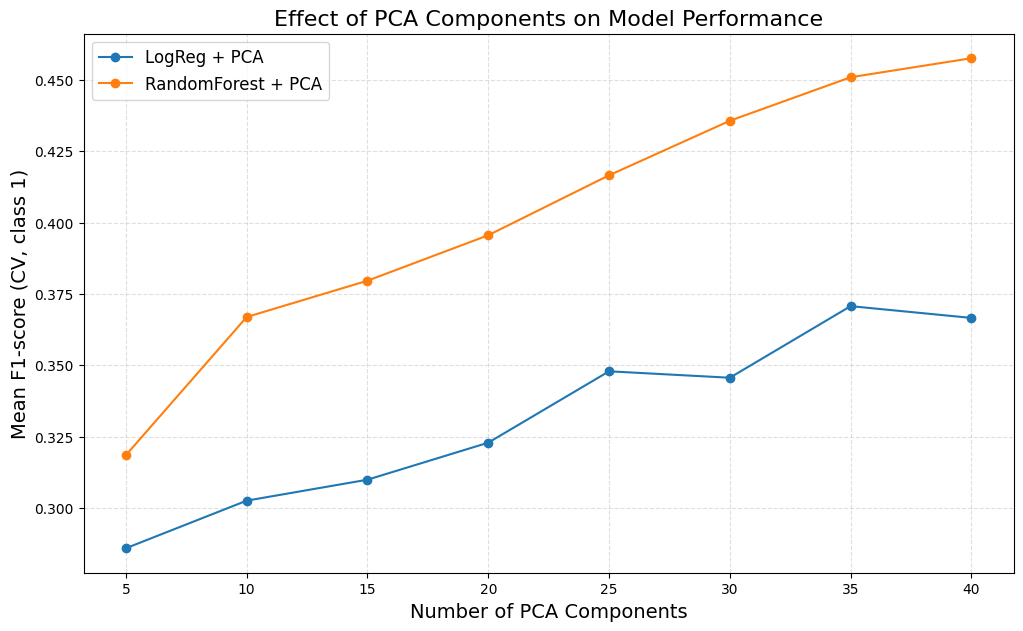

In [ ]:
# PCA values to test
pca_list = list(range(5, 41, 5))  # 5, 10, 15, ..., 40

results = []

# cross-validation settings
f1_scorer = make_scorer(f1_score, pos_label=1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n in pca_list:

    print(f"\n=== Testing PCA with {n} components ===")

    # =============================
    # Logistic Regression + PCA + SMOTE
    # =============================
    lr_pca_pipe = ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('pca', PCA(n_components=n, random_state=42)),
        ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
        ('logreg', LogisticRegression(
            max_iter=1000,
            solver='liblinear',
            class_weight='balanced',
            C=0.5,
            penalty='l2',
            random_state=42
        ))
    ])

    lr_cv = cross_val_score(
        lr_pca_pipe, X_train, y_train,
        cv=skf, scoring=f1_scorer
    )

    results.append({
        "model": "LogReg + PCA",
        "n_components": n,
        "mean_f1": lr_cv.mean(),
        "std_f1": lr_cv.std()
    })

    # =============================
    # Random Forest + PCA + SMOTE
    # =============================
    rf_pca_pipe = ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('pca', PCA(n_components=n, random_state=42)),
        ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
        ('rf', RandomForestClassifier(
            n_estimators=500,
            class_weight='balanced_subsample',
            max_depth=8,
            min_samples_split=10,
            min_samples_leaf=4,
            random_state=42,
            n_jobs=-1
        ))
    ])

    rf_cv = cross_val_score(
        rf_pca_pipe, X_train, y_train,
        cv=skf, scoring=f1_scorer
    )

    results.append({
        "model": "RandomForest + PCA",
        "n_components": n,
        "mean_f1": rf_cv.mean(),
        "std_f1": rf_cv.std()
    })


# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\n=== RESULTS SUMMARY ===")
print(results_df)

# Plot
plt.figure(figsize=(12, 7))

for model_name, grp in results_df.groupby("model"):
    plt.plot(grp["n_components"], grp["mean_f1"], marker='o', label=model_name)

plt.xlabel("Number of PCA Components", fontsize=14)
plt.ylabel("Mean F1-score (CV, class 1)", fontsize=14)
plt.title("Effect of PCA Components on Model Performance", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=12)
plt.show()


=== Testing PCA with 36 components ===

=== Testing PCA with 37 components ===

=== Testing PCA with 38 components ===

=== Testing PCA with 39 components ===

=== RESULTS SUMMARY ===
                model  n_components   mean_f1    std_f1
0        LogReg + PCA            36  0.370276  0.003829
1  RandomForest + PCA            36  0.453106  0.008204
2        LogReg + PCA            37  0.369377  0.004047
3  RandomForest + PCA            37  0.455426  0.006877
4        LogReg + PCA            38  0.368300  0.003427
5  RandomForest + PCA            38  0.451875  0.005199
6        LogReg + PCA            39  0.367280  0.004322
7  RandomForest + PCA            39  0.458855  0.006688


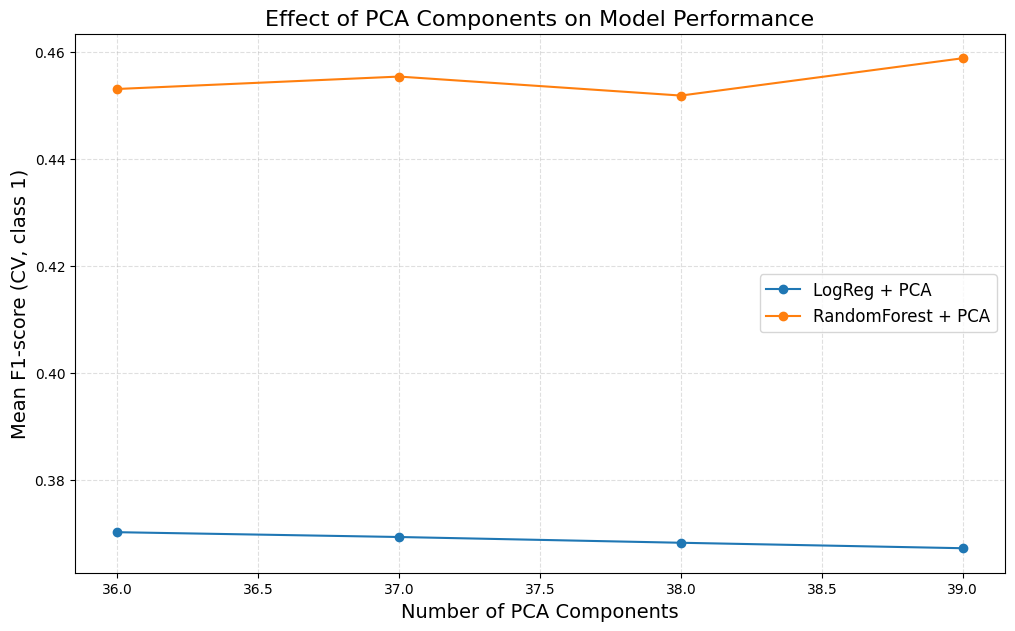

In [ ]:
# PCA values to test
pca_list = list(range(36, 40, 1))

results = []

# cross-validation settings
f1_scorer = make_scorer(f1_score, pos_label=1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n in pca_list:

    print(f"\n=== Testing PCA with {n} components ===")

    # =============================
    # Logistic Regression + PCA + SMOTE
    # =============================
    lr_pca_pipe = ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('pca', PCA(n_components=n, random_state=42)),
        ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
        ('logreg', LogisticRegression(
            max_iter=1000,
            solver='liblinear',
            class_weight='balanced',
            C=0.5,
            penalty='l2',
            random_state=42
        ))
    ])

    lr_cv = cross_val_score(
        lr_pca_pipe, X_train, y_train,
        cv=skf, scoring=f1_scorer
    )

    results.append({
        "model": "LogReg + PCA",
        "n_components": n,
        "mean_f1": lr_cv.mean(),
        "std_f1": lr_cv.std()
    })

    # =============================
    # Random Forest + PCA + SMOTE
    # =============================
    rf_pca_pipe = ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('pca', PCA(n_components=n, random_state=42)),
        ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
        ('rf', RandomForestClassifier(
            n_estimators=500,
            class_weight='balanced_subsample',
            max_depth=8,
            min_samples_split=10,
            min_samples_leaf=4,
            random_state=42,
            n_jobs=-1
        ))
    ])

    rf_cv = cross_val_score(
        rf_pca_pipe, X_train, y_train,
        cv=skf, scoring=f1_scorer
    )

    results.append({
        "model": "RandomForest + PCA",
        "n_components": n,
        "mean_f1": rf_cv.mean(),
        "std_f1": rf_cv.std()
    })


# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\n=== RESULTS SUMMARY ===")
print(results_df)

# Plot
plt.figure(figsize=(12, 7))

for model_name, grp in results_df.groupby("model"):
    plt.plot(grp["n_components"], grp["mean_f1"], marker='o', label=model_name)

plt.xlabel("Number of PCA Components", fontsize=14)
plt.ylabel("Mean F1-score (CV, class 1)", fontsize=14)
plt.title("Effect of PCA Components on Model Performance", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=12)
plt.show()

In [ ]:
# ==============================
# Logistic Regression + SMOTE
# ==============================

log_reg_smote = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
    ('logreg', LogisticRegression(
        max_iter=1000,
        solver='liblinear',
        class_weight='balanced',
        C=0.5,
        penalty='l2',
        random_state=42
    ))
])

# CV settings
f1_scorer = make_scorer(f1_score, pos_label=1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# run CV
cv_f1_scores = cross_val_score(
    log_reg_smote,
    X_train,
    y_train,
    cv=skf,
    scoring=f1_scorer
)

print("\n===== Stratified 5-fold CV (Logistic with SMOTE) =====")
print("F1 (class 1) per fold:", np.round(cv_f1_scores, 4))
print("Mean F1:", cv_f1_scores.mean().round(4), "  Std:", cv_f1_scores.std().round(4))

# fit pipeline on training set
log_reg_smote.fit(X_train, y_train)


===== Stratified 5-fold CV (Logistic with SMOTE) =====
F1 (class 1) per fold: [0.3659 0.3707 0.366  0.3683 0.3618]
Mean F1: 0.3665   Std: 0.0029


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance',
                                                   'day_of_week', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('logreg',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    max_iter=1000, random_state=42,
                                    solver='liblinear'))])

In [ ]:
# logistic regression (SMOTE) train accuracy
y_pred_train_log_smote = log_reg_smote.predict(X_train)

train_acc_log_smote = accuracy_score(y_train, y_pred_train_log_smote)
print(f"Logistic Regression (with SMOTE) Train Accuracy: {train_acc_log_smote:.4f}")

# logistic regression (SMOTE) test accuracy
y_pred_log_smote = log_reg_smote.predict(X_test)

test_acc_log_smote = accuracy_score(y_test, y_pred_log_smote)
conf_matrix_log = confusion_matrix(y_test, y_pred_log_smote)

print(f"\nLogistic Regression (with SMOTE) Test Accuracy: {test_acc_log_smote:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_log)

Logistic Regression (with SMOTE) Train Accuracy: 0.7547

Logistic Regression (with SMOTE) Test Accuracy: 0.7564

Confusion Matrix:
[[6176 1809]
 [ 394  664]]


In [ ]:
# ==============================
# Random Forest + SMOTE
# ==============================

rfc_smote = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=500,
        class_weight='balanced_subsample',
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1
    ))
])

# CV settings
f1_scorer = make_scorer(f1_score, pos_label=1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# run CV
cv_f1_scores = cross_val_score(
    rfc_smote,
    X_train,
    y_train,
    cv=skf,
    scoring=f1_scorer
)

print("\n===== Stratified 5-fold CV (Random Forest with SMOTE) =====")
print("F1 (class 1) per fold:", np.round(cv_f1_scores, 4))
print("Mean F1:", cv_f1_scores.mean().round(4), "  Std:", cv_f1_scores.std().round(4))

# fit pipeline on training set
rfc_smote.fit(X_train, y_train)


===== Stratified 5-fold CV (Random Forest with SMOTE) =====
F1 (class 1) per fold: [0.4361 0.4182 0.4322 0.4185 0.4224]
Mean F1: 0.4255   Std: 0.0073


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance',
                                                   'day_of_week', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=8, min_samples_leaf=4,
                                        min_samples_split=10, n_estimators=500,
                                        n_jobs=-1, random_state=42))])

In [ ]:
# random forest (with SMOTE) train accuracy
y_pred_train_rf_smote = rfc_smote.predict(X_train)

train_acc_rf_smote = accuracy_score(y_train, y_pred_train_rf_smote)
print(f"Random Forest (with SMOTE) - Train Accuracy: {train_acc_rf_smote:.4f}")

# random forest (with SMOTE) test accuracy
y_pred_test_rf_smote = rfc_smote.predict(X_test)

test_acc_rf_smote = accuracy_score(y_test, y_pred_test_rf_smote)
conf_matrix_rf_smote = confusion_matrix(y_test, y_pred_test_rf_smote)

print(f"\nRandom Forest (with SMOTE) - Test Accuracy: {test_acc_rf_smote:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_rf_smote)

Random Forest (with SMOTE) - Train Accuracy: 0.8276

Random Forest (with SMOTE) - Test Accuracy: 0.8171

Confusion Matrix:
[[6777 1208]
 [ 446  612]]


In [ ]:
# ==================================
# Logistic Regression + PCA + SMOTE
# ==================================

pca = PCA(n_components=39, random_state=42)

log_reg_pca_smote = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('pca', pca),
    ('smote', SMOTE(sampling_strategy=0.3,
                    random_state=42)),
    ('logreg', LogisticRegression(
        max_iter=1000,
        solver='liblinear',
        class_weight='balanced',
        C=0.5,
        penalty='l2',
        random_state=42
    ))
])

# CV settings
f1_scorer = make_scorer(f1_score, pos_label=1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# run CV
cv_f1_scores_lr_pca = cross_val_score(
    log_reg_pca_smote,
    X_train,
    y_train,
    cv=skf,
    scoring=f1_scorer
)

print("\n===== Stratified 5-fold CV (Logistic + SMOTE + PCA) =====")
print("F1 (class 1) per fold:", np.round(cv_f1_scores_lr_pca, 4))
print("Mean F1:", cv_f1_scores_lr_pca.mean().round(4),
      " Std:", cv_f1_scores_lr_pca.std().round(4))

log_reg_pca_smote.fit(X_train, y_train)


===== Stratified 5-fold CV (Logistic + SMOTE + PCA) =====
F1 (class 1) per fold: [0.3674 0.3729 0.3664 0.3698 0.3599]
Mean F1: 0.3673  Std: 0.0043


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance',
                                                   'day_of_week', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('pca', PCA(n_components=39, random_state=42)),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('logreg',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    max_iter=1000, random_state=42,
                                    solver='liblinear'))])

In [ ]:
# logistic regression (with PCA and SMOTE) train accuracy
y_pred_train_log_pca_smote = log_reg_pca_smote.predict(X_train)

train_acc_log_pca_smote = accuracy_score(y_train, y_pred_train_log_pca_smote)
print(f"Logistic Regression (with PCA and SMOTE) Train Accuracy: {train_acc_log_pca_smote:.4f}")

# logistic regression (with PCA and SMOTE) test accuracy
y_pred_log_pca_smote = log_reg_pca_smote.predict(X_test)

test_acc_log_pca_smote = accuracy_score(y_test, y_pred_log_pca_smote)
conf_matrix_log_pca_smote = confusion_matrix(y_test, y_pred_log_pca_smote)

print(f"\nLogistic Regression (with PCA and SMOTE) Test Accuracy: {test_acc_log_pca_smote:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_log_pca_smote)

Logistic Regression (with PCA and SMOTE) Train Accuracy: 0.7558

Logistic Regression (with PCA and SMOTE) Test Accuracy: 0.7557

Confusion Matrix:
[[6173 1812]
 [ 397  661]]


In [ ]:
# ==============================
# Random Forest + PCA + SMOTE
# ==============================

pca_rf = PCA(n_components=39, random_state=42)

rfc_pca_smote = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('pca', pca_rf),
    ('smote', SMOTE(sampling_strategy=0.3,
                    random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=500,
        class_weight='balanced_subsample',
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1
    ))
])

cv_f1_scores_rf_pca = cross_val_score(
    rfc_pca_smote,
    X_train,
    y_train,
    cv=skf,
    scoring=f1_scorer
)

print("\n===== Stratified 5-fold CV (Random Forest + PCA + SMOTE) =====")
print("F1 (class 1) per fold:", np.round(cv_f1_scores_rf_pca, 4))
print("Mean F1:", cv_f1_scores_rf_pca.mean().round(4),
      " Std:", cv_f1_scores_rf_pca.std().round(4))

rfc_pca_smote.fit(X_train, y_train)


===== Stratified 5-fold CV (Random Forest + PCA + SMOTE) =====
F1 (class 1) per fold: [0.4503 0.4673 0.458  0.4531 0.4656]
Mean F1: 0.4589  Std: 0.0067


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance',
                                                   'day_of_week', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('pca', PCA(n_components=39, random_state=42)),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=8, min_samples_leaf=4,
                                        min_samples_split=10, n_estimators=500,
                                        n_jobs=-1, random_state=42))])

In [ ]:
# random forest (with PCA and SMOTE) train accuracy
y_pred_train_rf_pca_smote = rfc_pca_smote.predict(X_train)

train_acc_rf_smote = accuracy_score(y_train, y_pred_train_rf_pca_smote)
print(f"Random Forest (with PCA and SMOTE) - Train Accuracy: {train_acc_rf_smote:.4f}")

# random forest (with PCA and SMOTE) test accuracy
y_pred_test_rf_pca_smote = rfc_pca_smote.predict(X_test)

test_acc_rf_pca_smote = accuracy_score(y_test, y_pred_test_rf_pca_smote)
conf_matrix_rf_pca_smote = confusion_matrix(y_test, y_pred_test_rf_pca_smote)

print(f"\nRandom Forest (with PCA and SMOTE) - Test Accuracy: {test_acc_rf_pca_smote:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_rf_pca_smote)

Random Forest (with PCA and SMOTE) - Train Accuracy: 0.8686

Random Forest (with PCA and SMOTE) - Test Accuracy: 0.8569

Confusion Matrix:
[[7182  803]
 [ 491  567]]



===== Logistic Regression (SMOTE) =====
Accuracy      : 0.7564
Precision (1) : 0.2685
Recall (1)    : 0.6276
F1-score (1)  : 0.3761
ROC-AUC       : 0.7699
PR-AUC        : 0.4082

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      7985
           1       0.27      0.63      0.38      1058

    accuracy                           0.76      9043
   macro avg       0.60      0.70      0.61      9043
weighted avg       0.86      0.76      0.79      9043



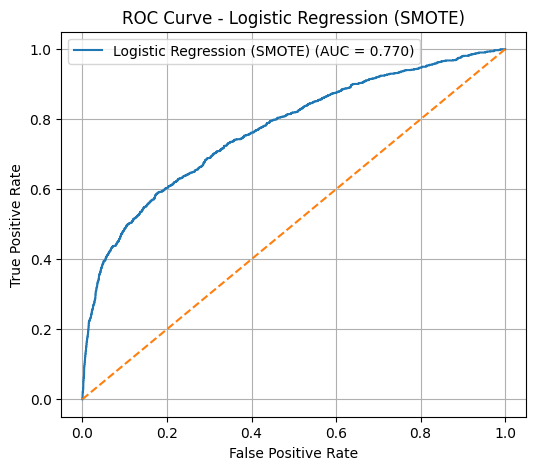

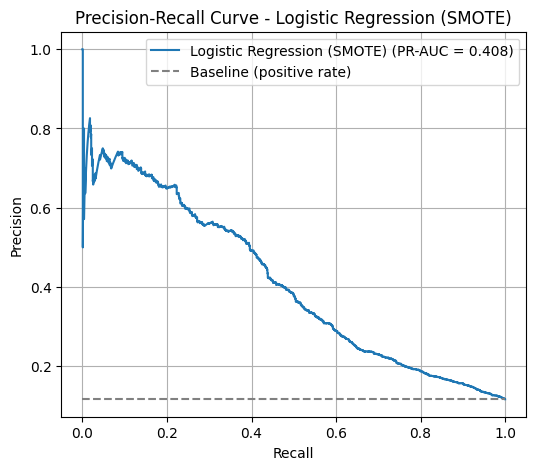


===== Logistic Regression (PCA + SMOTE) =====
Accuracy      : 0.7557
Precision (1) : 0.2673
Recall (1)    : 0.6248
F1-score (1)  : 0.3744
ROC-AUC       : 0.7697
PR-AUC        : 0.4082

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      7985
           1       0.27      0.62      0.37      1058

    accuracy                           0.76      9043
   macro avg       0.60      0.70      0.61      9043
weighted avg       0.86      0.76      0.79      9043



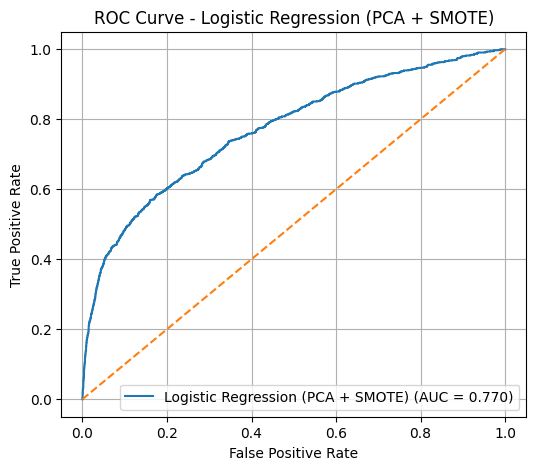

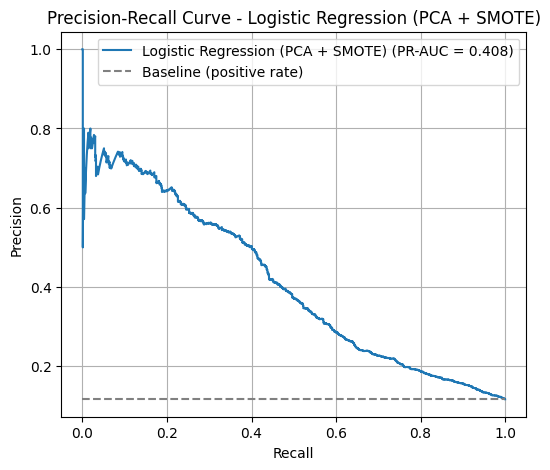


===== Random Forest (SMOTE) =====
Accuracy      : 0.8171
Precision (1) : 0.3363
Recall (1)    : 0.5784
F1-score (1)  : 0.4253
ROC-AUC       : 0.7841
PR-AUC        : 0.4181

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      7985
           1       0.34      0.58      0.43      1058

    accuracy                           0.82      9043
   macro avg       0.64      0.71      0.66      9043
weighted avg       0.87      0.82      0.84      9043



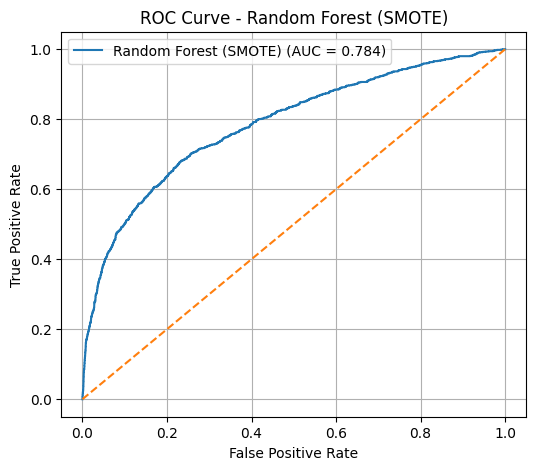

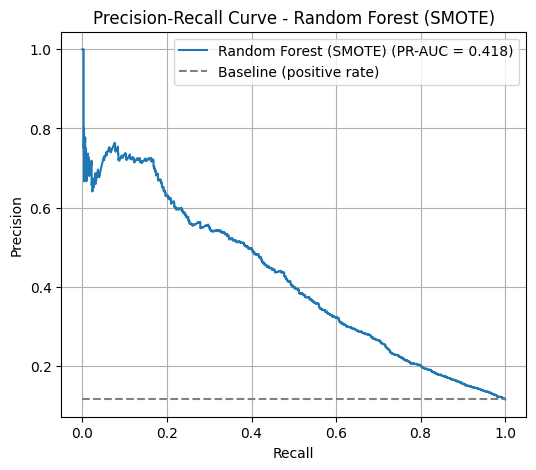


===== Random Forest (PCA + SMOTE) =====
Accuracy      : 0.8569
Precision (1) : 0.4139
Recall (1)    : 0.5359
F1-score (1)  : 0.4671
ROC-AUC       : 0.7916
PR-AUC        : 0.4351

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      7985
           1       0.41      0.54      0.47      1058

    accuracy                           0.86      9043
   macro avg       0.67      0.72      0.69      9043
weighted avg       0.87      0.86      0.86      9043



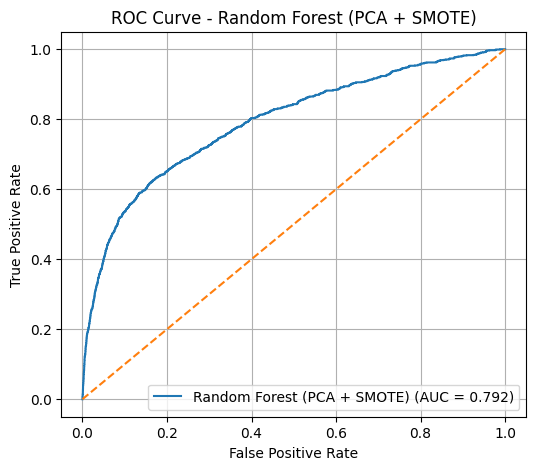

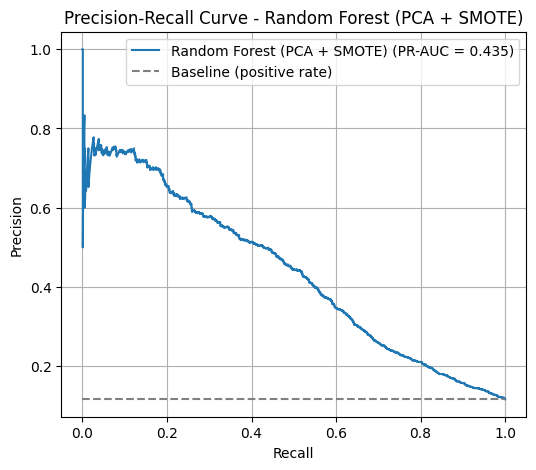

,model,accuracy,precision_1,recall_1,f1_1,roc_auc,pr_auc
0,Logistic Regression (SMOTE),0.756386,0.268500,0.627599,0.376097,0.769877,0.408221
1,Logistic Regression (PCA + SMOTE),0.755723,0.267287,0.624764,0.374398,0.769735,0.408156
2,Random Forest (SMOTE),0.817096,0.336264,0.578450,0.425295,0.784059,0.418118
3,Random Forest (PCA + SMOTE),0.856906,0.413869,0.535917,0.467051,0.791565,0.435124


In [ ]:
def evaluate_model(name, model, X_test, y_test, pos_label=1):

    # prediction (class) and probability of positive class
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # basic metrics
    acc   = accuracy_score(y_test, y_pred)
    prec  = precision_score(y_test, y_pred, pos_label=pos_label)
    rec   = recall_score(y_test, y_pred, pos_label=pos_label)
    f1    = f1_score(y_test, y_pred, pos_label=pos_label)
    rocA  = roc_auc_score(y_test, y_proba)
    prA   = average_precision_score(y_test, y_proba)  # PR-AUC

    print(f"\n===== {name} =====")
    print(f"Accuracy      : {acc:.4f}")
    print(f"Precision (1) : {prec:.4f}")
    print(f"Recall (1)    : {rec:.4f}")
    print(f"F1-score (1)  : {f1:.4f}")
    print(f"ROC-AUC       : {rocA:.4f}")
    print(f"PR-AUC        : {prA:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    # ---------- ROC curve ----------
    fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=pos_label)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {rocA:.3f})")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------- Precision-Recall curve ----------
    prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba, pos_label=pos_label)
    plt.figure(figsize=(6,5))
    plt.plot(rec_curve, prec_curve, label=f"{name} (PR-AUC = {prA:.3f})")
    baseline = y_test.mean()  # positive rate
    plt.hlines(baseline, 0, 1, colors="gray", linestyles="--", label="Baseline (positive rate)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # return metrics dict
    return {
        "model": name,
        "accuracy": acc,
        "precision_1": prec,
        "recall_1": rec,
        "f1_1": f1,
        "roc_auc": rocA,
        "pr_auc": prA
    }

results = []

results.append(evaluate_model("Logistic Regression (SMOTE)",    log_reg_smote, X_test, y_test))
results.append(evaluate_model("Logistic Regression (PCA + SMOTE)",    log_reg_pca_smote, X_test, y_test))
results.append(evaluate_model("Random Forest (SMOTE)",          rfc_smote, X_test, y_test))
results.append(evaluate_model("Random Forest (PCA + SMOTE)",          rfc_pca_smote, X_test, y_test))

results_df = pd.DataFrame(results)
results_df

PLOT: PERFORMANCE METRICS COMPARISON

Logistic Regression (SMOTE):
  PR-AUC    : 0.4082
  ROC-AUC   : 0.7699
  Precision : 0.2685
  Recall    : 0.6276
  F1-Score  : 0.3761

Random Forest (SMOTE):
  PR-AUC    : 0.4181
  ROC-AUC   : 0.7841
  Precision : 0.3363
  Recall    : 0.5784
  F1-Score  : 0.4253

Logistic Regression (PCA + SMOTE):
  PR-AUC    : 0.4082
  ROC-AUC   : 0.7697
  Precision : 0.2673
  Recall    : 0.6248
  F1-Score  : 0.3744

Random Forest (PCA + SMOTE):
  PR-AUC    : 0.4351
  ROC-AUC   : 0.7916
  Precision : 0.4139
  Recall    : 0.5359
  F1-Score  : 0.4671


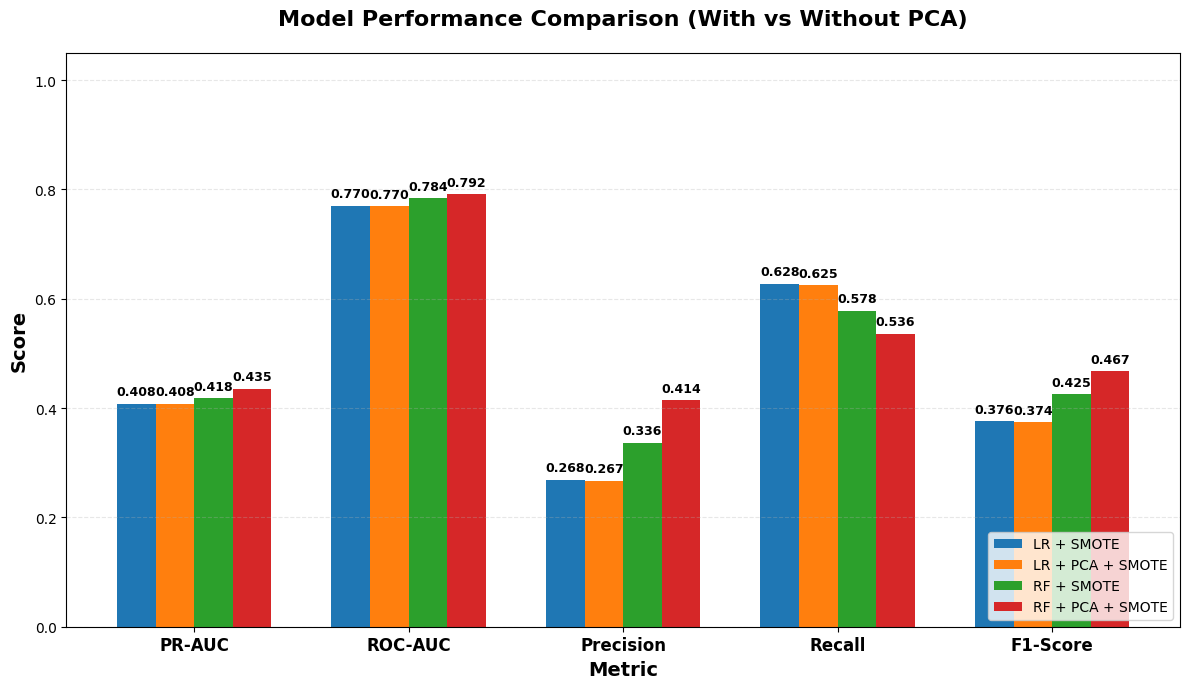

In [ ]:
print("="*70)
print("PLOT: PERFORMANCE METRICS COMPARISON")
print("="*70)

lr_row     = results_df[results_df["model"] == "Logistic Regression (SMOTE)"].iloc[0]
rf_row     = results_df[results_df["model"] == "Random Forest (SMOTE)"].iloc[0]
lr_pca_row = results_df[results_df["model"] == "Logistic Regression (PCA + SMOTE)"].iloc[0]
rf_pca_row = results_df[results_df["model"] == "Random Forest (PCA + SMOTE)"].iloc[0]

metrics = ["PR-AUC", "ROC-AUC", "Precision", "Recall", "F1-Score"]

lr_scores = [
    lr_row["pr_auc"],
    lr_row["roc_auc"],
    lr_row["precision_1"],
    lr_row["recall_1"],
    lr_row["f1_1"],
]

rf_scores = [
    rf_row["pr_auc"],
    rf_row["roc_auc"],
    rf_row["precision_1"],
    rf_row["recall_1"],
    rf_row["f1_1"],
]

lr_pca_scores = [
    lr_pca_row["pr_auc"],
    lr_pca_row["roc_auc"],
    lr_pca_row["precision_1"],
    lr_pca_row["recall_1"],
    lr_pca_row["f1_1"],
]

rf_pca_scores = [
    rf_pca_row["pr_auc"],
    rf_pca_row["roc_auc"],
    rf_pca_row["precision_1"],
    rf_pca_row["recall_1"],
    rf_pca_row["f1_1"],
]

print("\nLogistic Regression (SMOTE):")
print(f"  PR-AUC    : {lr_scores[0]:.4f}")
print(f"  ROC-AUC   : {lr_scores[1]:.4f}")
print(f"  Precision : {lr_scores[2]:.4f}")
print(f"  Recall    : {lr_scores[3]:.4f}")
print(f"  F1-Score  : {lr_scores[4]:.4f}")

print("\nRandom Forest (SMOTE):")
print(f"  PR-AUC    : {rf_scores[0]:.4f}")
print(f"  ROC-AUC   : {rf_scores[1]:.4f}")
print(f"  Precision : {rf_scores[2]:.4f}")
print(f"  Recall    : {rf_scores[3]:.4f}")
print(f"  F1-Score  : {rf_scores[4]:.4f}")

print("\nLogistic Regression (PCA + SMOTE):")
print(f"  PR-AUC    : {lr_pca_scores[0]:.4f}")
print(f"  ROC-AUC   : {lr_pca_scores[1]:.4f}")
print(f"  Precision : {lr_pca_scores[2]:.4f}")
print(f"  Recall    : {lr_pca_scores[3]:.4f}")
print(f"  F1-Score  : {lr_pca_scores[4]:.4f}")

print("\nRandom Forest (PCA + SMOTE):")
print(f"  PR-AUC    : {rf_pca_scores[0]:.4f}")
print(f"  ROC-AUC   : {rf_pca_scores[1]:.4f}")
print(f"  Precision : {rf_pca_scores[2]:.4f}")
print(f"  Recall    : {rf_pca_scores[3]:.4f}")
print(f"  F1-Score  : {rf_pca_scores[4]:.4f}")

# ----------------- Plot -----------------
x = np.arange(len(metrics))
width = 0.18

fig, ax = plt.subplots(figsize=(12, 7))

bars_lr      = ax.bar(x - 1.5*width, lr_scores,      width, label="LR + SMOTE")
bars_lr_pca  = ax.bar(x - 0.5*width, lr_pca_scores,  width, label="LR + PCA + SMOTE")
bars_rf      = ax.bar(x + 0.5*width, rf_scores,      width, label="RF + SMOTE")
bars_rf_pca  = ax.bar(x + 1.5*width, rf_pca_scores,  width, label="RF + PCA + SMOTE")

def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + 0.01,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold"
        )

annotate_bars(bars_lr)
annotate_bars(bars_lr_pca)
annotate_bars(bars_rf)
annotate_bars(bars_rf_pca)

ax.set_ylabel("Score", fontsize=14, fontweight="bold")
ax.set_xlabel("Metric", fontsize=14, fontweight="bold")
ax.set_title("Model Performance Comparison (With vs Without PCA)",
             fontsize=16, fontweight="bold", pad=20)

ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12, fontweight="bold")
ax.legend(fontsize=10, loc="lower right")
ax.grid(True, alpha=0.3, axis="y", linestyle="--")
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()


**Feature Importance**

The feature 'poutcome_success' appears as the most important predictor in the Random Forest model, as it has the highest importance score among all variables. This indicates that information about whether a client previously subscribed during an earlier marketing campaign provides the strongest signal for predicting subscription in the current campaign.

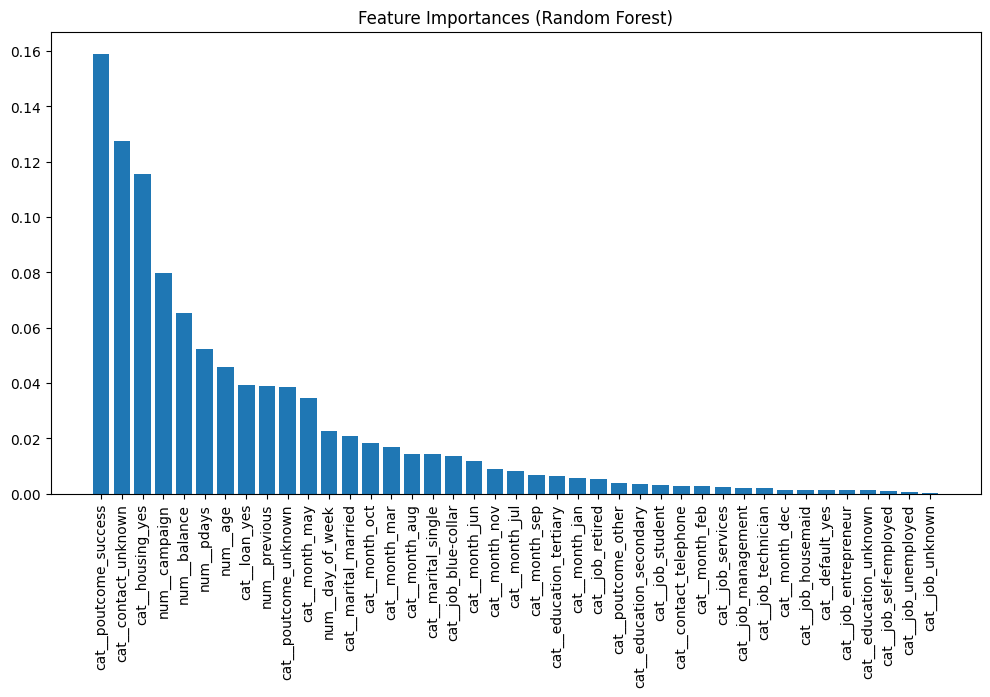

In [ ]:
rfc_smote.fit(X_train, y_train)

rf_model = rfc_smote.named_steps['rf']

# Get feature importances
importances = rf_model.feature_importances_

# Get feature names from preprocessor
feature_names = preprocessor.get_feature_names_out()

# Create DataFrame
fi = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(12,6))
plt.bar(fi['feature'], fi['importance'])
plt.xticks(rotation=90)
plt.title("Feature Importances (Random Forest)")
plt.show()

# **Section 5: Discussion**

**Implications**

- Machine learning can help banks do better at focusing their marketing campaigns. This lets them find customers who are more likely to subscribe instead of using general outreach methods.

- PR-AUC and F1-score emerge as more meaningful evaluation metrics than accuracy on imbalanced datasets, providing clearer insight into minority-class performance.

- SMOTE enhances minority-class detection by creating synthetic examples of the positive class. Although not a complete solution to imbalance, it meaningfully improves recall and F1-score across all models.

- PCA is especially useful for models built on trees when PCA is used, Random Forest gets much better in terms of precision, F1-score, PR-AUC, and ROC-AUC. This means that PCA removes noisy or duplicate features that make it harder for trees to split.

**Limitations**

- Precision remains low for all models, even after applying SMOTE. This indicats a high number of false positives.

- SMOTE may generate synthetic patterns that do not perfectly reflect real customer behavior, potentially affecting generalizability.

- PCA makes it harder to understand the features, even though it helps Random Forest perform better.

- The dataset covers the period 2008–2010, and customer behavior or marketing practices may have changed significantly since then, which may limit practical applicability of the results.

# **Section 6: Conclusion**

This project evaluated four classification models, including Logistic Regression (SMOTE), Logistic Regression (PCA and SMOTE), Random Forest (SMOTE), and Random Forest (PCA and SMOTE) to predict customer subscription behavior in the Bank Marketing dataset.

The models were evaluated through cross-validation and multiple performance metrics designed for imbalanced data. Random Forest consistently outperformed Logistic Regression in precision, F1-score, PR-AUC, and ROC-AUC, while maintaining reasonable recall. Overall, Random Forest with PCA and SMOTE was identified as the most effective model, achieving the highest performance across metrics, including a CV mean F1-score of 0.4589 (Std = 0.0067), test-set precision of 0.4139, F1-score of 0.4671, PR-AUC of 0.4351, and ROC-AUC of 0.7916.


Feature importance analysis was conducted for the Random Forest model as the best-performing model. It revealed that 'poutcome_success', 'contact_unknown', and several campaign-related variables were among the strongest predictors of subscription. These insights provide actionable value for marketing teams by highlighting the factors that most strongly influence customer conversion.